# Time Delay Neural Network(TDNN)

In [16]:

from __future__ import print_function
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils


import seaborn as sns

from sklearn import preprocessing
from scipy import stats

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



In [17]:
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def convert_to_float(x):

    return np.float(x)


In [19]:
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    
    df.dropna(axis=0, how='any', inplace=True)

    return df


In [20]:
def create_segments_and_labels(df, time_steps, step, label_name):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels

    """

    # x, y, z acceleration as features
    N_FEATURES = 3
    
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels



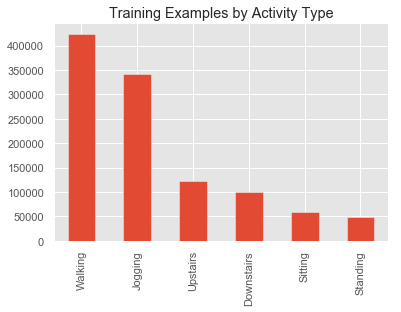

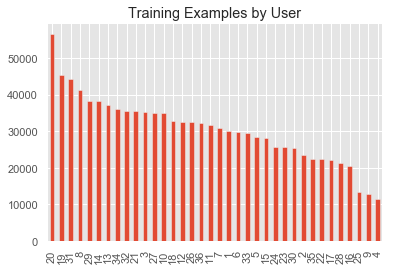

In [21]:
pd.options.display.float_format = '{:.1f}'.format
sns.set() 
plt.style.use('ggplot')

LABELS = ["Downstairs",
          "Jogging",
          "Sitting",
          "Standing",
          "Upstairs",
          "Walking"]
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40


# Load data set containing all the data from csv
df = read_data('Data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')

# Describe the data

df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()

df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

for activity in np.unique(df["activity"]):
    subset = df[df["activity"] == activity][:180]
   # plot_activity(activity, subset)

# Define column name of the label vector
LABEL = "ActivityEncoded"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df["activity"].values.ravel())



In [22]:
# Differentiate between test set and training set
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

# Normalize features for training data set
df_train['x-axis'] = feature_normalize(df['x-axis'])
df_train['y-axis'] = feature_normalize(df['y-axis'])
df_train['z-axis'] = feature_normalize(df['z-axis'])

df_train = df_train.round({'x-axis': 6, 'y-axis': 6, 'z-axis': 6})


C:\Users\samya\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\samya\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\samya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

In [23]:
x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)


In [24]:
print('x_train shape: ', x_train.shape)
# Displays (20869, 40, 3)
print(x_train.shape[0], 'training samples')
# Displays 20869 train samples

# Inspect y data
print('y_train shape: ', y_train.shape)
# Displays (20869,)

# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))


x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)
['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [25]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)

print('x_train shape:', x_train.shape)
# x_train shape: (20869, 120)
print('input_shape:', input_shape)
# input_shape: (120)

# Convert type for Keras otherwise Keras cannot process the data
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")



x_train shape: (20868, 240)
input_shape: 240


# Execute this part only once then Comment

In [30]:
y_train = np_utils.to_categorical(y_train, num_classes)
#print('New y_train shape: ', y_train.shape)


In [31]:
model = Sequential()
model.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model.add(Conv1D(100, 10, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(160, 10, activation='relu'))
model.add(Conv1D(160, 10, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 71, 100)           3100      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 62, 100)           100100    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 100)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 11, 160)           160160    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 2, 160)            256160    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 160)              

In [32]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

In [33]:
sam = model.fit(x_train,y_train,epochs = 50,batch_size = 128)

Epoch 1/50
20868/20868 [==============================] - 20s 948us/sample - loss: 0.4984 - acc: 0.8204
Epoch 2/50
20868/20868 [==============================] - 15s 717us/sample - loss: 0.2410 - acc: 0.9194
Epoch 3/50
20868/20868 [==============================] - 9s 419us/sample - loss: 0.1724 - acc: 0.9428
Epoch 4/50
20868/20868 [==============================] - 9s 436us/sample - loss: 0.1585 - acc: 0.9466
Epoch 5/50
20868/20868 [==============================] - 9s 436us/sample - loss: 0.1091 - acc: 0.9650
Epoch 6/50
20868/20868 [==============================] - 9s 431us/sample - loss: 0.0899 - acc: 0.9710s 
Epoch 7/50
20868/20868 [==============================] - 9s 417us/sample - loss: 0.0774 - acc: 0.9747
Epoch 8/50
20868/20868 [==============================] - 9s 410us/sample - loss: 0.0535 - acc: 0.9831
Epoch 9/50
20868/20868 [==============================] - 9s 433us/sample - loss: 0.0658 - acc: 0.9791
Epoch 10/50
20868/20868 [==============================] - 10s 501us/

# Training Accuracy of 99.84%

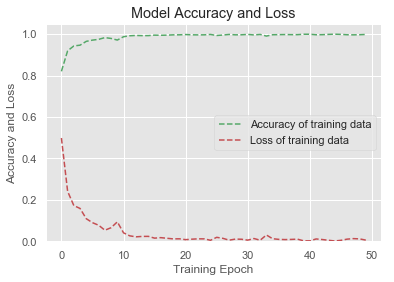

In [34]:
plt.figure(figsize=(6, 4))
plt.plot(sam.history['acc'], "g--", label="Accuracy of training data")
plt.plot(sam.history['loss'], "r--", label="Loss of training data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()


In [35]:
df_test['x-axis'] = feature_normalize(df_test['x-axis'])
df_test['y-axis'] = feature_normalize(df_test['y-axis'])
df_test['z-axis'] = feature_normalize(df_test['z-axis'])

df_test = df_test.round({'x-axis': 6, 'y-axis': 6, 'z-axis': 6})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, num_classes)

C:\Users\samya\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\samya\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\samya\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [36]:
model.evaluate(x_test,y_test)

6584/6584 [==============================] - 1s 149us/sample - loss: 1.2761 - acc: 0.8932


[1.2761423395177938, 0.893226]

# Testing Accuracy of 89.32%